<a href="https://www.kaggle.com/code/romanvelichkin/guide-to-image-classification-in-pytorch?scriptVersionId=157281014" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Step by step guide for image classification in PyTorch

Link to used pistachio image dataset: https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset

This guide explains how to fine-tune pretrained and train own models for image classification using PyTorch. You will know how to create binary and multi-class image classification models. Also guide shows how to use trained models for classification tasks.

However, this guide still requires knowledge of how to work with deep neural networks. This is a good start if you know the theory but have never tried it in practice.

Guide contains:
1. Data exploration and preparation.
1. Fine-tuning YOLO classification model. This model is great for starting because it's working out of box and very easy to use.
2. Fine-tuning small EfficientNetV2 from package.
3. Creation of own AlexNet model from scratch.

<b>Don't forget to turn on GPU acceleration in notebook settings! Otherwise training will be much slower.</b>

# Imports

In [2]:
import random
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# Make sure plots will work in notebook
%matplotlib inline

# Data preparation and exploration

## Set path to source images

In [4]:
DATA_DIR = '/kaggle/input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset/'
WORK_DIR = '/kaggle/working'

## Copy file function

In [5]:
# Function for copying files
def copy_file(from_path, to_path, file):
    if os.path.exists(os.path.join(from_path, file)):
        shutil.copyfile(os.path.join(from_path, file), os.path.join(to_path, file))

## Explore data

In [82]:
# How many pistachio types we have 
# Save them as list with categories

categories = []

for category_dir in os.listdir(DATA_DIR):
    # Take only subfolders - they contain images
    if os.path.isdir(os.path.join(DATA_DIR, category_dir)):
        categories.append(category_dir)
    
print('We have those categories of pistachios:', categories)    

We have those categories of pistachios: ['Kirmizi_Pistachio', 'Siirt_Pistachio']


In [7]:
# Build dataframe with images and labels from both types of pistachio
images_labels_list = []

for category in categories:
    lst = [(file, category) for file in os.listdir(os.path.join(DATA_DIR, category))] 
    images_labels_list += lst
    
pistachio_data = pd.DataFrame(images_labels_list, columns=['id', 'label'])

In [8]:
# Save created dataframe
pistachio_data_path = os.path.join(WORK_DIR, 'pistachio_data.csv')
pistachio_data.to_csv(pistachio_data_path, index=False)

In [9]:
# Base info about created dataframe
pistachio_data.info()
pistachio_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2148 non-null   object
 1   label   2148 non-null   object
dtypes: object(2)
memory usage: 33.7+ KB


,id,label
0,kirmizi 1109.jpg,Kirmizi_Pistachio
1,kirmizi (10).jpg,Kirmizi_Pistachio
2,kirmizi 97.jpg,Kirmizi_Pistachio
3,kirmizi 475.jpg,Kirmizi_Pistachio
4,kirmizi 29.jpg,Kirmizi_Pistachio


label
Kirmizi_Pistachio    1232
Siirt_Pistachio       916
Name: count, dtype: int64


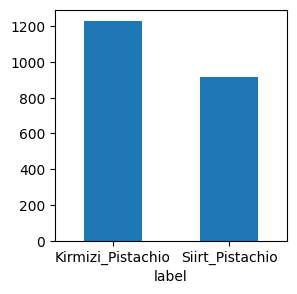

In [10]:
# How many images of each type we have
print(pistachio_data['label'].value_counts())
pistachio_data['label'].value_counts().plot(figsize=(3, 3), kind='bar', rot=0);

#### Show both categories of pistachios to visual comparison
Show random image frome each category of pistachios. Each time you run cell - you will see different images.

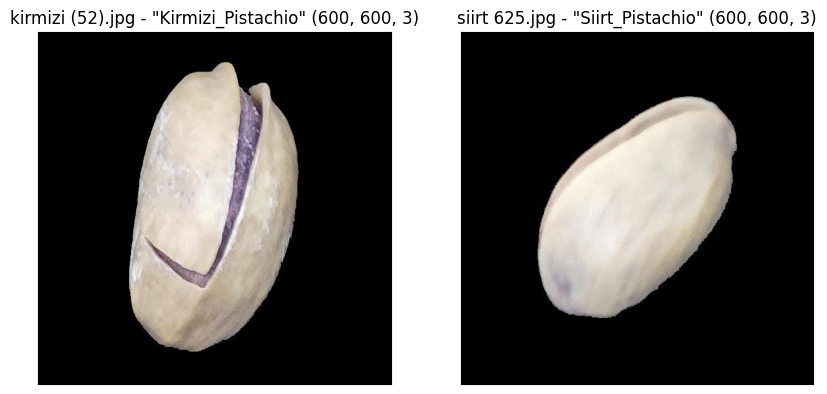

In [11]:
# Prepare plot to show images
fig, axes = plt.subplots(1, len(categories), figsize=(10, 5))
# Save amount of images in each category
categories_count = dict(pistachio_data['label'].value_counts())

# Show image for each category
for i in range(len(categories)):
    category = categories[i]
    
    # Get random image from selected category
    img_num = random.randrange(categories_count[category])
    df = pistachio_data[(pistachio_data['label'] == category)]
    img_name, _ = df.iloc[img_num]
    
    # Open that image
    img_path = os.path.join(DATA_DIR, category, img_name)
    img = plt.imread(img_path)
    
    # Draw plot with that image
    img = plt.imread(img_path)
    axes[i].set_title(f'{img_name} - "{category}" {img.shape}')

    # Hide X and Y axes tick marks
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
    axes[i].imshow(img)

To be honest, I'm not sure I would be able to distinguish one type of pistachios from another.

## Split data into training and validation datasets
You can skip this part if you done it already. You can load data in next chapter.

In [12]:
# Get images and their labels
X = pistachio_data['id']
y = pistachio_data['label']

# Split data into train and val datasets (85% and 15%)
# Usually around 25-33% goes to validations dataset
# But in this case we don't have that much data to efficiently train model, so keep validation dataset smaller
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# Split train data into train and test datasets (75% and 10%)
# 11% from 85% ~ 10% from 100% 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.11, random_state=42)

# Train dataset
pistachio_data_train = pd.DataFrame(columns=['id', 'label'])
pistachio_data_train['id'] = X_train
pistachio_data_train['label'] = y_train

# Val dataset
pistachio_data_val = pd.DataFrame(columns=['id', 'label'])
pistachio_data_val['id'] = X_val
pistachio_data_val['label'] = y_val

# Test dataset
pistachio_data_test = pd.DataFrame(columns=['id', 'label'])
pistachio_data_test['id'] = X_test
pistachio_data_test['label'] = y_test

# Check amount of images in each dataset
print('Total images:', len(pistachio_data))
print(f'Train + val + test = {len(pistachio_data_train)} + {len(pistachio_data_val)} + {len(pistachio_data_test)}'
      f' = {len(pistachio_data_train) + len(pistachio_data_val) + len(pistachio_data_test)}')

Total images: 2148
Train + val + test = 1624 + 323 + 201 = 2148


#### Data distirbution in train, val and test datasets

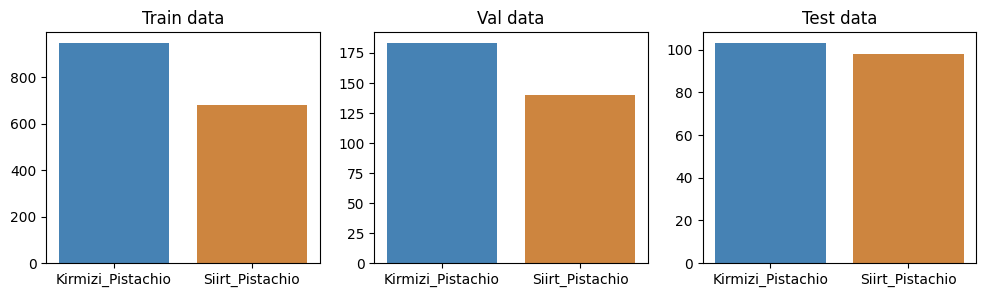

In [13]:
# Create plots for data distribution in train and val datasets
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

train_count = pistachio_data_train['label'].value_counts()
val_count = pistachio_data_val['label'].value_counts()
test_count = pistachio_data_test['label'].value_counts()
colors=['steelblue', 'peru']

axs[0].bar(train_count.index, train_count.values, color=colors)
axs[0].set_title('Train data')

axs[1].bar(val_count.index, val_count.values, color=colors)
axs[1].set_title('Val data')

axs[2].bar(test_count.index, test_count.values, color=colors)
axs[2].set_title('Test data')

plt.show();

#### Save train and val datasets

In [14]:
pistachio_data_train_path = os.path.join(WORK_DIR, 'pistachio_data_train.csv')
pistachio_data_train.to_csv(pistachio_data_train_path, index=False)

pistachio_data_val_path = os.path.join(WORK_DIR, 'pistachio_data_val.csv')
pistachio_data_val.to_csv('pistachio_data_val.csv', index=False)

pistachio_data_test_path = os.path.join(WORK_DIR, 'pistachio_data_test.csv')
pistachio_data_test.to_csv('pistachio_data_test.csv', index=False)

## Prepare test data
Let's save the test data in a separate folder, so that when working with them we can simulate a situation where data analysis takes place on real unlabeled data.

In [15]:
TEST_DATA_DIR = os.path.join(WORK_DIR, 'test_data')

# create folder for test data
if not os.path.isdir(TEST_DATA_DIR):
    os.mkdir(TEST_DATA_DIR)
    print('Created folder:', TEST_DATA_DIR)
else:
    print('Folder exists already:', TEST_DATA_DIR)

Created folder: /kaggle/working/test_data


In [16]:
# Copy train data
for i in range(len(pistachio_data_test)):
    copy_file(os.path.join(DATA_DIR, pistachio_data_test.iloc[i]['label']), 
              TEST_DATA_DIR,
              pistachio_data_test.iloc[i]['id'])

# Check that data was copied correctly
file_counter = 0

for file in os.listdir(TEST_DATA_DIR):
    file_counter += 1
    
if len(pistachio_data_test) == file_counter:
    print('Test images were copied succesfully!')
else:
    print('Something went wrong! Folder with test data contains wrong amount of images!')

Test images were copied succesfully!


## Load pistachio data: full, train, val and test datasets
If you split data and saved it in .csv files before, then you can load it now.

In [17]:
# Read full data from file
pistachio_data = pd.read_csv('pistachio_data.csv')

# Read train and test data from file
pistachio_data_train = pd.read_csv('pistachio_data_train.csv')
pistachio_data_val = pd.read_csv('pistachio_data_val.csv')
pistachio_data_test = pd.read_csv('pistachio_data_test.csv')

# Fine-tune pretrained YOLO model

You can read about this model here: https://docs.ultralytics.com/
        
First we'll try the easiest way to classify images - using YOLO from Ultralytics. It's designed to work right out of the box with minimal effort on your part.

In [18]:
# Install YOLO Ultralytics
!pip install ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/98/44/71231f2da4fb4a602d0cef2071adb708199e571ef89ed4a136f59c19d733/ultralytics-8.0.231-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 5.4 MB/s eta 0:00:0000:0100:01


### Prepare data for YOLO
YOLO from Ultralytics has workflow that is a bit different from usual PyTorch workflow.

It accepts data in hierarchical form - the parent folder contains the "train", "val" and "test" folders. Each of these folders contains folders with the names of the image categories and the corresponding images inside.

Example:
<br>
- <b>parent_folder</b>
- - <b>train</b>
- - - <b>category_1</b>
- - - - category_1_img_0.jpg
- - - - category_1_img_1.jpg
- - - <b>category_2</b>
- - - - category_2_img_0.jpg
- - - - category_2_img_1.jpg
- - - <b>category_3</b>
- - - - category_3_img_0.jpg
- - - - category_3_img_1.jpg
- - <b>val</b>
- - - <b>category_1</b>
- - - - category_1_img_2.jpg
- - - - category_1_img_3.jpg
- - - <b>category_2</b>
<br>
... etc

#### Prepare data in hierarchical form

In [19]:
# Create folders for training and validation datasets
YOLO_DATA_DIR = os.path.join(WORK_DIR, 'yolo_data')
YOLO_TRAIN_DIR = os.path.join(YOLO_DATA_DIR, 'train')
YOLO_VAL_DIR = os.path.join(YOLO_DATA_DIR, 'val')

# create parent folder for YOLO data
if not os.path.isdir(YOLO_DATA_DIR):
    os.mkdir(YOLO_DATA_DIR)
    print('Created folder:', YOLO_DATA_DIR)
else:
    print('Folder exists already:', YOLO_DATA_DIR)

# create subfolder for train data
if not os.path.isdir(YOLO_TRAIN_DIR):
    os.mkdir(YOLO_TRAIN_DIR)
    print('Created folder:', YOLO_TRAIN_DIR)
else:
    print('Folder exists already:', YOLO_TRAIN_DIR)
    
# create subfolder for val data
if not os.path.isdir(YOLO_VAL_DIR):
    os.mkdir(YOLO_VAL_DIR)
    print('Created folder:', YOLO_VAL_DIR)
else:
    print('Folder exists already:', YOLO_VAL_DIR)

Created folder: /kaggle/working/yolo_data
Created folder: /kaggle/working/yolo_data/train
Created folder: /kaggle/working/yolo_data/val


In [20]:
# Create category subfolders for training and validation datasets
for category in categories:
    
    # Train category subfolders
    subfolder_path = os.path.join(YOLO_TRAIN_DIR, category)
    if not os.path.isdir(subfolder_path):
        os.mkdir(subfolder_path)
        print('Created folder: ', subfolder_path)
    else:
        print('Folder exists already:', subfolder_path)
        
    # Val category subfolders
    subfolder_path = os.path.join(YOLO_VAL_DIR, category)
    if not os.path.isdir(subfolder_path):
        os.mkdir(subfolder_path)
        print('Created folder: ', subfolder_path)
    else:
        print('Folder exists already:', subfolder_path)

Created folder:  /kaggle/working/yolo_data/train/Kirmizi_Pistachio
Created folder:  /kaggle/working/yolo_data/val/Kirmizi_Pistachio
Created folder:  /kaggle/working/yolo_data/train/Siirt_Pistachio
Created folder:  /kaggle/working/yolo_data/val/Siirt_Pistachio


In [21]:
# Copy train data
for i in range(len(pistachio_data_train)):
    copy_file(os.path.join(DATA_DIR, pistachio_data_train.iloc[i]['label']), 
              os.path.join(YOLO_TRAIN_DIR, pistachio_data_train.iloc[i]['label']), 
              pistachio_data_train.iloc[i]['id'])           
    
# Check that data was copied correctly
file_counter = 0

for category_dir in os.listdir(YOLO_TRAIN_DIR):
    for file in os.listdir(os.path.join(YOLO_TRAIN_DIR, category_dir)):
        file_counter += 1
    
if len(pistachio_data_train) == file_counter:
    print('Train images for YOLO were copied succesfully!')
else:
    print('Something went wrong! Folder with train YOLO data contains wrong amount of images!')

Train images for YOLO were copied succesfully!


In [22]:
# Copy val data
for i in range(len(pistachio_data_val)):
    copy_file(os.path.join(DATA_DIR, pistachio_data_val.iloc[i]['label']), 
              os.path.join(YOLO_VAL_DIR, pistachio_data_val.iloc[i]['label']), 
              pistachio_data_val.iloc[i]['id'])
    
# Check that data was copied correctly
file_counter = 0

for category_dir in os.listdir(YOLO_VAL_DIR):
    for file in os.listdir(os.path.join(YOLO_VAL_DIR, category_dir)):
        file_counter += 1
    
if len(pistachio_data_val) == file_counter:
    print('Val images for YOLO were copied succesfully!')
else:
    print('Something went wrong! Folder with val YOLO data contains wrong amount of images!')

Val images for YOLO were copied succesfully!


### Train with YOLO

In [23]:
from ultralytics import YOLO

# Load YOLO model weights for image classification
# Read more about this model: https://docs.ultralytics.com/tasks/classify/
model = YOLO('yolov8n-cls.pt')

100%|██████████| 5.28M/5.28M [00:00<00:00, 60.4MB/s]


Images will be resized from 600x600 to 224x224 because that's the input resolution for YOLO by default.

In [24]:
# Disable logging training history with wandb.ai, which is implemented by default
import wandb
wandb.init(mode='disabled')

# Train model
# More about it: https://docs.ultralytics.com/modes/train/
# Feel free to experiment with parameters
results = model.train(data=YOLO_DATA_DIR, # path to data
                      save=True, # save trained model
                      plots=True,
                      epochs=20, 
                      imgsz=224, # resize input images to 224x224 size
                      patience=3, # stop training and restore best weights if there is no improvement after 3 epochs
                      batch=32,
                      device=0, # run on GPU
                      optimizer='Adam',
                      lr0=0.0001, # default lr for Adam is 0.001, but for fine tuning it is better to choose a lower rate
                      lrf=0.0001, # no changes in learning rate during training
                      dropout=0.5)

Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/kaggle/working/yolo_data, epochs=20, time=None, patience=3, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.5, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=N

2024-01-01 07:46:12,656	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-01-01 07:46:13,378	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=1000 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralyti

100%|██████████| 6.23M/6.23M [00:00<00:00, 70.9MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/yolo_data/train... 1624 images, 0 corrupt: 100%|██████████| 1624/1624 [00:00<00:00, 2573.47it/s]

train: New cache created: /kaggle/working/yolo_data/train.cache


albumentations: RandomResizedCrop(p=1.0, height=224, width=224, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1), HorizontalFlip(p=0.5), ColorJitter(p=0.5, brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.30000000000000004, 1.7], hue=[-0.015, 0.015]), Normalize(p=1.0, mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0), ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)


val: Scanning /kaggle/working/yolo_data/val... 323 images, 0 corrupt: 100%|██████████| 323/323 [00:00<00:00, 2692.57it/s]

val: New cache created: /kaggle/working/yolo_data/val.cache


optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


/opt/conda/lib/python3.10/site-packages/torch/jit/_trace.py:1084: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 2 / 2 (100.0%)
Greatest absolute difference: 1.0786632597446442 at index (0, 0) (up to 1e-05 allowed)
Greatest relative difference: 6.605060676289324 at index (0, 1) (up to 1e-05 allowed)
  _check_trace(
       1/20     0.652G     0.5371         32        224:  29%|██▉       | 15/51 [00:03<00:03,  9.79it/s]

       1/20     0.652G     0.4373         32        224:  53%|█████▎    | 27/51 [00:04<00:02, 11.45it/s]
100%|██████████| 755k/755k [00:00<00:00, 11.9MB/s]  224:  53%|█████▎    | 27/51 [00:04<00:02, 11.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 17.48it/s]

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 35.38it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 39.16it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 43.01it/s]

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 37.13it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:00<00:00, 40.76it/s]

                   all      0.978          1
Stopping training early as no improvement observed in last 3 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



6 epochs completed in 0.010 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.1MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.1MB

Validating runs/classify/train/weights/best.pt...
Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8n-cls summary (fused): 73 layers, 1437442 parameters, 0 gradients, 3.3 GFLOPs
train: /kaggle/working/yolo_data/train... found 1624 images in 2 classes ✅ 
val: /kaggle/working/yolo_data/val... found 323 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 6/6 [00:01<00:00,  5.67it/s]


                   all      0.991          1
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Results saved to runs/classify/train


In [25]:
# Look training results
print(results)

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f2b3c4612d0>
curves: []
curves_results: []
fitness: 0.995356023311615
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.99071204662323, 'metrics/accuracy_top5': 1.0, 'fitness': 0.995356023311615}
save_dir: PosixPath('runs/classify/train')
speed: {'preprocess': 0.18124978977829312, 'inference': 2.034264083248174, 'loss': 0.00040745218471845975, 'postprocess': 0.00038087921614986454}
task: 'classify'
top1: 0.99071204662323
top5: 1.0


#### Show training results plots

In [26]:
# Get path to saved training results
results_path = results.save_dir
results_path

PosixPath('runs/classify/train')

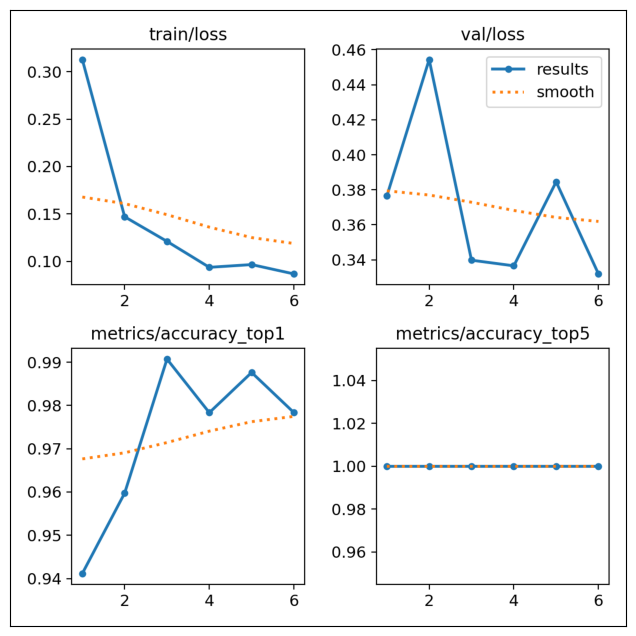

In [27]:
# Training history
history_path = os.path.join(results_path, 'results.png')
img = plt.imread(history_path)
plt.figure(figsize=(8, 8))
plt.xticks([])
plt.yticks([])
plt.imshow(img);

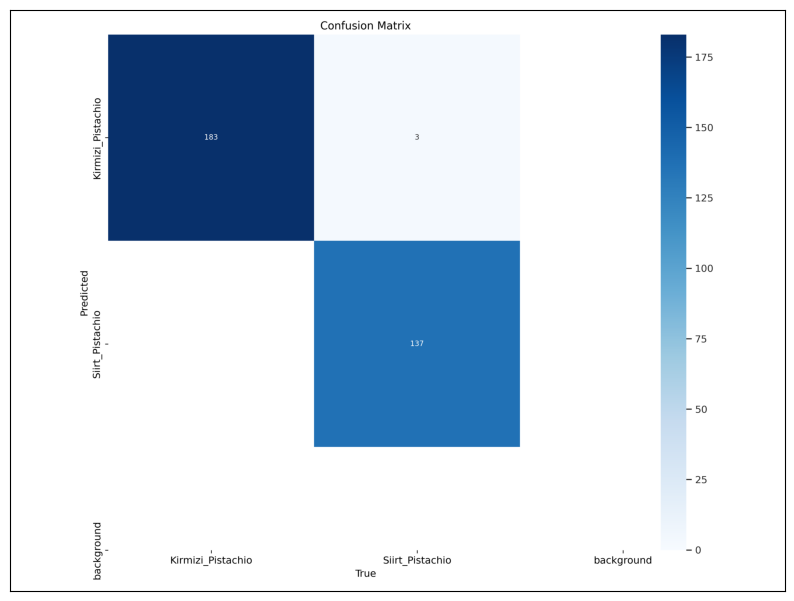

In [28]:
# Confusion matrix
confusion_matrix_path = os.path.join(results_path, 'confusion_matrix.png')
img = plt.imread(confusion_matrix_path)
plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(img);

### How to use fine-tuned YOLO

In [29]:
# Model's weights with least loss were saved. Now we can load them and use for predictions.

# Load trained model weights
weights_path = os.path.join(results.save_dir, 'weights', 'best.pt')
loaded_model = YOLO(weights_path)

In [30]:
# Test model on validation dataset
# It accepts same parent folder with "train" and "val" subfolders in it
val_results = loaded_model.val(data=YOLO_DATA_DIR)

Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8n-cls summary (fused): 73 layers, 1437442 parameters, 0 gradients, 3.3 GFLOPs
train: /kaggle/working/yolo_data/train... found 1624 images in 2 classes ✅ 
val: /kaggle/working/yolo_data/val... found 323 images in 2 classes ✅ 
test: None...


val: Scanning /kaggle/working/yolo_data/val... 323 images, 0 corrupt: 100%|██████████| 323/323 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:01<00:00, 12.09it/s]


                   all      0.991          1
Speed: 0.7ms preprocess, 2.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val


#### Using trained model for prediction

In [31]:
# Get test images and labels
pistachio_data_test = pd.read_csv('pistachio_data_test.csv')
pistachio_data_test[:5]

,id,label
0,kirmizi 118.jpg,Kirmizi_Pistachio
1,kirmizi 191.jpg,Kirmizi_Pistachio
2,kirmizi 681.jpg,Kirmizi_Pistachio
3,kirmizi 230.jpg,Kirmizi_Pistachio
4,kirmizi 1084.jpg,Kirmizi_Pistachio


In [32]:
# Predict on test data
prediction_results = loaded_model.predict(TEST_DATA_DIR)


image 1/201 /kaggle/working/test_data/kirmizi (18).jpg: 224x224 Kirmizi_Pistachio 1.00, Siirt_Pistachio 0.00, 3.2ms
image 2/201 /kaggle/working/test_data/kirmizi 100.jpg: 224x224 Kirmizi_Pistachio 1.00, Siirt_Pistachio 0.00, 4.1ms
image 3/201 /kaggle/working/test_data/kirmizi 1000.jpg: 224x224 Kirmizi_Pistachio 1.00, Siirt_Pistachio 0.00, 4.1ms
image 4/201 /kaggle/working/test_data/kirmizi 1007.jpg: 224x224 Kirmizi_Pistachio 0.98, Siirt_Pistachio 0.02, 3.8ms
image 5/201 /kaggle/working/test_data/kirmizi 1017.jpg: 224x224 Kirmizi_Pistachio 1.00, Siirt_Pistachio 0.00, 3.9ms
image 6/201 /kaggle/working/test_data/kirmizi 1019.jpg: 224x224 Kirmizi_Pistachio 1.00, Siirt_Pistachio 0.00, 3.5ms
image 7/201 /kaggle/working/test_data/kirmizi 1028.jpg: 224x224 Kirmizi_Pistachio 1.00, Siirt_Pistachio 0.00, 4.1ms
image 8/201 /kaggle/working/test_data/kirmizi 1058.jpg: 224x224 Kirmizi_Pistachio 1.00, Siirt_Pistachio 0.00, 4.1ms
image 9/201 /kaggle/working/test_data/kirmizi 1066.jpg: 224x224 Kirmizi_

YOLO prediction results is hierarchical array, so you have to loop over it.

In [33]:
# Check what prediction results look like
for result in prediction_results[:5]:
    print('Image filename:', result.path)
    print('Predictions:', result.probs.data)
    print('Predicted category:', result.probs.top1)
    print()

Image filename: /kaggle/working/test_data/kirmizi (18).jpg
Predictions: tensor([0.9952, 0.0048], device='cuda:0')
Predicted category: 0

Image filename: /kaggle/working/test_data/kirmizi 100.jpg
Predictions: tensor([9.9970e-01, 3.0299e-04], device='cuda:0')
Predicted category: 0

Image filename: /kaggle/working/test_data/kirmizi 1000.jpg
Predictions: tensor([9.9991e-01, 8.5603e-05], device='cuda:0')
Predicted category: 0

Image filename: /kaggle/working/test_data/kirmizi 1007.jpg
Predictions: tensor([0.9785, 0.0215], device='cuda:0')
Predicted category: 0

Image filename: /kaggle/working/test_data/kirmizi 1017.jpg
Predictions: tensor([0.9958, 0.0042], device='cuda:0')
Predicted category: 0



In [34]:
# Calculate accuracy of predictions

# Check if predictions were made wrong
if len(prediction_results) != len(pistachio_data_test):
    print('Something wrong! "Predictions" contains different amount of images than "pistachio_data_test"')

# Get category names
categories = []

for category_dir in os.listdir(DATA_DIR):
    # Take only subfolders - they contain images
    if os.path.isdir(os.path.join(DATA_DIR, category_dir)):
        categories.append(category_dir)

# Set variable to count correct predictions
correct_predictions = 0
    
# Count correct predictions
for result in prediction_results:
    image_name = os.path.basename(result.path)
    pred_label = categories[result.probs.top1]
    
    # Row orders in 'pistachio_data_test' and 'prediction_results' are different
    # So we need to get groud truth label by image name
    ground_truth_label = pistachio_data_test.loc[pistachio_data_test['id'] == image_name]['label'].item()
    
    if ground_truth_label == pred_label:
        correct_predictions += 1

print('Accuracy of predictions on test data:', correct_predictions / len(prediction_results))

Accuracy of predictions on test data: 0.9950248756218906


# Prepare boilerplate code for PyTorch

In [36]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.transforms import v2

# Set GPU as default device for training
# All models will be placed to GPU after creation
# However, some data still needs to be transferred to the GPU manually.
torch.set_default_device('cuda')


# Drawing progress bars
from tqdm import tqdm

### Functions to prepare datasets

There is used two-class dataset, which is usually classified by using binary image classification. But for for educational purposes there is also example of code for multi-class image classification.

With little changes you can easily change swap between two types of classification or remove unnecessary code.

In [37]:
# Create a dataset class for storing and processing labeled data (training or validation)
class LabeledImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.images_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images_labels)

    def __getitem__(self, idx):
        img_name = self.images_labels.iloc[idx]['id']
        label = self.images_labels.iloc[idx]['label']
        categories = list(self.images_labels['label'].unique())
        
        # Images are stored in label-named folders
        img_path = os.path.join(self.img_dir, label, img_name) 
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label=label, categories=categories)
        return image, label

In [38]:
# Dataset class for making predictions on unlabeled data (test).
class UnlabeledImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_list = os.listdir(img_dir)
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        
        img_path = os.path.join(self.img_dir, img_name) 
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [39]:
# Function to encode label for binary image classification
def encode_label_binary(label, categories):
    """
    Function encodes label into 0 or 1 for binary classification 
    
    :label: named label.
    :categories: list with categories we need to classify.
    :return: encoded label.
    """
    # Each label have to be float and in array form
    encoded_label = torch.tensor([float(categories.index(label))])
    return encoded_label

In [40]:
# Function to encode label for multi-class image classification
def encode_label_multi_class(label, categories):
    """
    Function encodes label with one hot encoding for multi-class classification.
    One hot encoding ex.: label='category1', categories=['category0', 'category1', 'category2'], return=[0, 1, 0].
    
    :label: named label.
    :categories: list with categories we need to classify.
    :return: encoded label.
    """
    encoded_label = torch.zeros(len(categories))
    index = categories.index(label)
    encoded_label[index] = 1
    return encoded_label

### Functions for training process

In [41]:
def calculate_accuracy_binary(outputs, targets):
    """
    Function calculates accuracy of predictions. Outputs are numbers between 0 and 1, and rounded to closest value. 
    After that values compared with targets which are 0 and 1 numbers.
    
    :outputs: tensor array with float values between 0 and 1 - one value per image.
    :targets: tensor array with float ground truth values 0 or 1 - one value per image. 
    :return: accuracy of predictions.
    """
    predicted = torch.round(outputs)
    correct = (predicted == targets).sum().item()  
    total = targets.size(0)
    
    return correct / total

In [42]:
def calculate_accuracy_multi_class(outputs, targets):
    """
    Function calculates accuracy of predictions. Outputs and targets are one hot encoding arrays.
    
    3 categories problem example:
    outputs = [0.9, 0.1, 0.], after torch.max(): _ (max value in outputs) = [0.9], predicted (value position in outputs) = [0]
    targets = [1.0, 0., 0.], , after torch.max(): _ (max value in targets) = [1.], targets (value position in targets) = [0]
    correct = count how many positions were perdicted correcly
    
    :outputs: tensor array with one hot encoded arrays per image.
    :targets: tensor array with one hot encoded arrays per image.
    :return: accuracy of predictions.
    """
    # from sofmax array: max value, max value position
    _, predicted = torch.max(outputs, dim=1)
    # from target array: max value, max value position
    _, targets = torch.max(targets, dim=1)  
    
    # count correct positions
    correct = (predicted == targets).sum().item()  
    total = targets.size(0)
    
    return correct / total

In [43]:
def train_loop(model, dataloader, loss_fn, optimizer, classification_type):
    """
    Function runs train epoch. During this epoch model's weights are tuned. 
    Also it calculates loss and accuracy reaching during this epoch.
    
    :model: Model that gets training.
    :dataloader: Dataloader with training data.
    :loss_fn: loss function used to calculate efficiency of model's predictions.
    :optimizer: optimizer to tune model's weights to increase accuracy of predictions.
    :classification_type: type of classification: binary or multi-class.
    """
    # We need to send data to GPU
    device = torch.device('cuda')
    
    progress_bar = tqdm(total=len(dataloader), ncols=100, position=0, leave=True)
    
    running_loss = 0
    running_accuracy = 0
    
    model.train()

    for images, labels in dataloader:
        # Send data to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = loss_fn(outputs, labels)
       
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # choose binary or multi-class classification accuracy to calculate
        if classification_type == 'binary':
            running_accuracy += calculate_accuracy_binary(outputs, labels)
        if classification_type == 'multi_class':
            running_accuracy += calculate_accuracy_multi_class(outputs, labels)
        
        progress_bar.update(1)
        
    loss = running_loss / len(dataloader)
    accuracy = running_accuracy / len(dataloader)
        
    progress_bar.close() 
    
    return loss, accuracy

In [44]:
def val_loop(model, dataloader, loss_fn, classification_type):
    """
    Function runs validation epoch. During this epoch tested model's accuracy on data it sees for first time.
    
    :model: Model that gets validation.
    :dataloader: Dataloader with validation data.
    :loss_fn: loss function used to calculate efficiency of model's predictions.
    :classification_type: type of classification: binary or multi-class.
    """
    # We need to send data to GPU
    device = torch.device('cuda')
    
    progress_bar = tqdm(total=len(dataloader), ncols=100, position=0, leave=True)
    
    running_loss = 0
    running_accuracy = 0
    
    model.eval()
    
    with torch.no_grad():
        for images, labels in dataloader:
            # Send data to GPU
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            loss = loss_fn(outputs, labels)
               
            running_loss += loss.item()
            
            # choose binary or multi-class classification accuracy to calculate
            if classification_type == 'binary':
                running_accuracy += calculate_accuracy_binary(outputs, labels)
            if classification_type == 'multi_class':
                running_accuracy += calculate_accuracy_multi_class(outputs, labels)
        
            progress_bar.update(1)
        
    loss = running_loss / len(dataloader)
    accuracy = running_accuracy / len(dataloader)
        
    progress_bar.close() 
    
    return loss, accuracy

In [45]:
class EarlyStopperLoss:
    """
    Class checks reached loss value for model every epoch. If loss value is not improving, it stops model training.
    Also it tells to saves model's weights after improving loss value. 
    """
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        # threshold, if loss get worse (increase) by that value - increase counter
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        
    def update_model_weights(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            return True
        else:
            return False

    def early_stop(self, validation_loss):
        # if you get better loss - reset counter
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        # if you get much worse (by delta value) loss - increase counter
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [46]:
class EarlyStopperAccuracy:
    """
    Class checks reached model's accuracy for every epoch. If accuracy is not improving, it stops model training.
    Also it tells to saves model's weights after improving accuracy. 
    """
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        # threshold, if accuracy get worse (decrease) by that value - increase counter
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_accuracy = 0
        
    def update_model_weights(self, validation_accuracy):
        if validation_accuracy > self.max_validation_accuracy:
            return True
        else:
            return False

    def early_stop(self, validation_accuracy):
        # if you get better accuracy - reset counter
        if validation_accuracy > self.max_validation_accuracy:
            self.max_validation_accuracy = validation_accuracy
            self.counter = 0

        # if you get much worse (by delta value) accuracy - increase counter
        elif validation_accuracy < (self.max_validation_accuracy - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Fine-tune pretrained EfficientNetV2

I used pretrained EfficientNetV2 from my favourite models pack: https://github.com/leondgarse/keras_cv_attention_models/.

In [47]:
# Due to bug, models from package can't use PyTorch if Tensorflow and Keras are also installed
!pip uninstall -y tensorflow keras
# Install pack of models for image classification
!pip install kecam

Found existing installation: tensorflow 2.13.0
Uninstalling tensorflow-2.13.0:
  Successfully uninstalled tensorflow-2.13.0
Found existing installation: keras 2.13.1
Uninstalling keras-2.13.1:
  Successfully uninstalled keras-2.13.1
  Obtaining dependency information for kecam from https://files.pythonhosted.org/packages/3e/04/13cd0a2276a307e63515a7a14ea7da318f129f080cdd8080706b50f9dbd1/kecam-1.3.24-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/91/f8/dfa32d06cfcbdb76bc46e0f5d69c537de33f4cedb1a15cd4746ab45a6a26/ftfy-6.1.3-py3-none-any.whl.metadata
  Obtaining dependency information for wcwidth<0.3.0,>=0.2.12 from https://files.pythonhosted.org/packages/31/b1/a59de0ad3aabb17523a39804f4c6df3ae87ead053a4e25362ae03d73d03a/wcwidth-0.2.12-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 787.3/787.3 kB 8.6 MB/s e

### Prepare data

I used EfficientNetV2 B0 with input size 224x224 - smallest model of this architecture.
So we need to prepare images according to this input size.

In [48]:
# List of transformation required for image before it will go to model
transforms = v2.Compose([
    v2.Resize(size=[224, 224], antialias=True), # 600 -> 224
    # ConvertImageDtype will be depricated soon. You will have to use ToDtype instead.
    v2.ConvertImageDtype(torch.float32), # scale pixel values from [0, 255] to [0, 1]
#     v2.ToDtype(torch.float32, scale=True),
])

In [49]:
# Create pytorch datasets using image transformations and label encoding
train_data = LabeledImageDataset(annotations_file='pistachio_data_train.csv', 
                                 img_dir=DATA_DIR,
                                 transform=transforms,
                                 # choose binary or multi-class classification encoder
#                                  target_transform=encode_label_binary, 
                                 target_transform=encode_label_multi_class,
                                ) 

val_data = LabeledImageDataset(annotations_file='pistachio_data_val.csv',
                               img_dir=DATA_DIR,
                               transform=transforms,
                               # choose binary or multi-class classification encoder
#                                target_transform=encode_label_binary, 
                               target_transform=encode_label_multi_class,
                              ) 

# Create pytorch dataloaders
# Shuffle training data - it improves training efficiency
train_dataloader = DataLoader(train_data, 
                              batch_size=32, 
                              generator=torch.Generator(device='cuda'),
                              shuffle=True)
val_dataloader = DataLoader(val_data, 
                            batch_size=32, 
                            generator=torch.Generator(device='cuda'),
                            shuffle=False)

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: 32
Label: tensor([0., 1.], device='cuda:0')


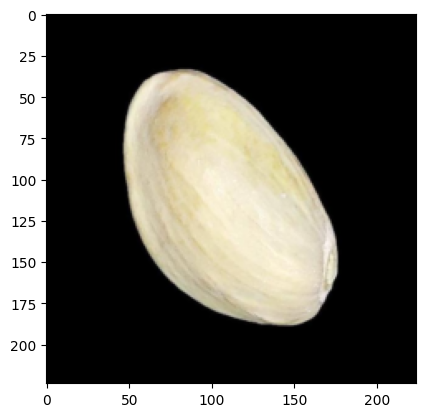

In [50]:
# Check created dataloaders
# Show image and label
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {len(train_labels)}')
img = train_features[0]
label = train_labels[0]
print(f'Label: {label}')
# PyTorch and Matplotlib have different channels order,  
img = torch.transpose(img, 0, 2) # transpose from [C, W, H] to [H, W, C]
img = torch.transpose(img, 0, 1) # transpose from [H, W, C] to [W, H, C]
plt.imshow(img);

### Prepare model
Load EfficientNetV2 B0 with imput size 224x224 - smallest model of this architecture.

In [60]:
# Set type image classification

# classification_type = 'binary'
classification_type = 'multi_class'

if classification_type == 'binary':
    activation_fn = 'sigmoid'
    num_classes = 1
    loss_fn = torch.nn.BCELoss()

# For multi-class image classification, the softmax activation function is commonly used.
# PyTorch CrossEntropyLoss already contains softmax function,
# so instead will be used linear function.
elif classification_type == 'multi_class':
    activation_fn = 'linear'
    num_classes = len(categories)
    loss_fn = torch.nn.CrossEntropyLoss()

In [61]:
# Use this model with PyTorch backend (by default it uses Keras)
os.environ['KECAM_BACKEND'] = 'torch'

# Import package with model we're going to use
from keras_cv_attention_models import efficientnet

In [62]:
# Create model, load pretrained weights
model = efficientnet.EfficientNetV2B0(pretrained='imagenet21k', # weights pretrained on imagenet21k
                                      num_classes=num_classes,
                                      classifier_activation=activation_fn,
                                      dropout=0.25,
                                     )

# Don't worry about warning - it says there is no weights to load for the last layer.
# That's ok - layer will be trained from scratch.

>>>> Aligned input_shape: [3, 224, 224]
>>>> Load pretrained from: /root/.keras/models/efficientnetv2-b0-21k.h5


In [54]:
# Make sure we have created a PyTorch model (not Tensorflow).
print(f'This is a PyTorch model: {isinstance(model, torch.nn.Module)}')

This is a PyTorch model: True


In [64]:
# Look model structure
print(f'Model structure: {model}')

Model structure: Model(
  (stem_conv): Sequential(
    (0): _SamePadding()
    (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  )
  (stem_bn): BatchNorm2d(32, eps=0.001, momentum=0.09999999999999998, affine=True, track_running_stats=True)
  (stem_swish): SiLU()
  (stack_0_block0_fu_conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (stack_0_block0_fu_bn): BatchNorm2d(16, eps=0.001, momentum=0.09999999999999998, affine=True, track_running_stats=True)
  (stack_0_block0_fu_swish): SiLU()
  (stack_0_block0_output): Identity()
  (stack_1_block0_sortcut_conv): Sequential(
    (0): _SamePadding()
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
  )
  (stack_1_block0_sortcut_bn): BatchNorm2d(64, eps=0.001, momentum=0.09999999999999998, affine=True, track_running_stats=True)
  (stack_1_block0_sortcut_swish): SiLU()
  (stack_1_block0_MB_pw_conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (stack_1_b

In [65]:
# Path to save model weights (we'll use them later)
EFFNET_WEIGHTS = os.path.join(WORK_DIR, 'EfficientNetV2_best_weights.pt')

#### Fine-tuning small EfficientNetV2

In [66]:
num_epochs = 20

# default lr for Adam is 0.001, but for fine-tuning it is better to choose a lower rate.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
early_stopper_accuracy = EarlyStopperAccuracy(patience=3, min_delta=0)

train_stats = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_loop(model=model, 
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            classification_type=classification_type)
        
    val_loss, val_accuracy = val_loop(model=model, 
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      classification_type=classification_type)
    
    result = (
        f'Epoch [{epoch+1}/{num_epochs}], '
        f'Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}, '
        f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.4f}'
    )
        
    print(result)
    
    # Collect training stats to draw plot later
    train_stats.append((train_loss, train_accuracy, val_loss, val_accuracy))
    
    # save weights with best results
    if early_stopper_accuracy.update_model_weights(val_accuracy):   
        torch.save(model.state_dict(), EFFNET_WEIGHTS)
        
    # early stopping
    if early_stopper_accuracy.early_stop(val_accuracy): 
        break

100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.70it/s]


Epoch [1/20], Train loss: 0.2027, Train accuracy: 0.9246, Val loss: 0.0354, Val accuracy: 0.9886


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.96it/s]


Epoch [2/20], Train loss: 0.0346, Train accuracy: 0.9875, Val loss: 0.0337, Val accuracy: 0.9886


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.99it/s]


Epoch [3/20], Train loss: 0.0141, Train accuracy: 0.9969, Val loss: 0.0330, Val accuracy: 0.9886


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.49it/s]


Epoch [4/20], Train loss: 0.0102, Train accuracy: 0.9969, Val loss: 0.0257, Val accuracy: 0.9915


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.39it/s]


Epoch [5/20], Train loss: 0.0052, Train accuracy: 0.9988, Val loss: 0.0304, Val accuracy: 0.9886


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.97it/s]


Epoch [6/20], Train loss: 0.0043, Train accuracy: 1.0000, Val loss: 0.0330, Val accuracy: 0.9915


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.46it/s]


Epoch [7/20], Train loss: 0.0040, Train accuracy: 0.9994, Val loss: 0.0269, Val accuracy: 0.9915


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.28it/s]


Epoch [8/20], Train loss: 0.0171, Train accuracy: 0.9933, Val loss: 0.0473, Val accuracy: 0.9915


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.20it/s]


Epoch [9/20], Train loss: 0.0046, Train accuracy: 0.9994, Val loss: 0.0356, Val accuracy: 0.9915


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.27it/s]


Epoch [10/20], Train loss: 0.0036, Train accuracy: 0.9982, Val loss: 0.0392, Val accuracy: 0.9915


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.12it/s]


Epoch [11/20], Train loss: 0.0032, Train accuracy: 0.9994, Val loss: 0.0531, Val accuracy: 0.9830


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.22it/s]


Epoch [12/20], Train loss: 0.0014, Train accuracy: 1.0000, Val loss: 0.0249, Val accuracy: 0.9943


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.36it/s]


Epoch [13/20], Train loss: 0.0059, Train accuracy: 0.9988, Val loss: 0.0826, Val accuracy: 0.9716


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.28it/s]


Epoch [14/20], Train loss: 0.0021, Train accuracy: 1.0000, Val loss: 0.0237, Val accuracy: 0.9943


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.33it/s]


Epoch [15/20], Train loss: 0.0064, Train accuracy: 0.9982, Val loss: 0.0252, Val accuracy: 0.9943


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.26it/s]


Epoch [16/20], Train loss: 0.0010, Train accuracy: 1.0000, Val loss: 0.0303, Val accuracy: 0.9943


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.13it/s]


Epoch [17/20], Train loss: 0.0022, Train accuracy: 0.9994, Val loss: 0.0486, Val accuracy: 0.9830


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.49it/s]

Epoch [18/20], Train loss: 0.0005, Train accuracy: 1.0000, Val loss: 0.0391, Val accuracy: 0.9830


#### Plot results of training EfficientNetV2

In [67]:
# Validation accuracy is higher than training because dropout layers are not working during model.eval()
train_data_df = pd.DataFrame(train_stats, columns=['train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])
train_data_df['train_accuracy'] = train_data_df['train_accuracy'] * 100
train_data_df['val_accuracy'] = train_data_df['val_accuracy'] * 100
train_data_df

,train_loss,train_accuracy,val_loss,val_accuracy
0,0.202743,92.463235,0.035408,98.863636
1,0.034618,98.754085,0.033689,98.863636
2,0.014054,99.693627,0.033043,98.863636
3,0.010214,99.693627,0.025698,99.147727
4,0.005155,99.877451,0.030407,98.863636
5,0.004306,100.000000,0.032954,99.147727
6,0.003998,99.938725,0.026928,99.147727
7,0.017121,99.325980,0.047277,99.147727
8,0.004558,99.938725,0.035561,99.147727
9,0.003647,99.816176,0.039196,99.147727


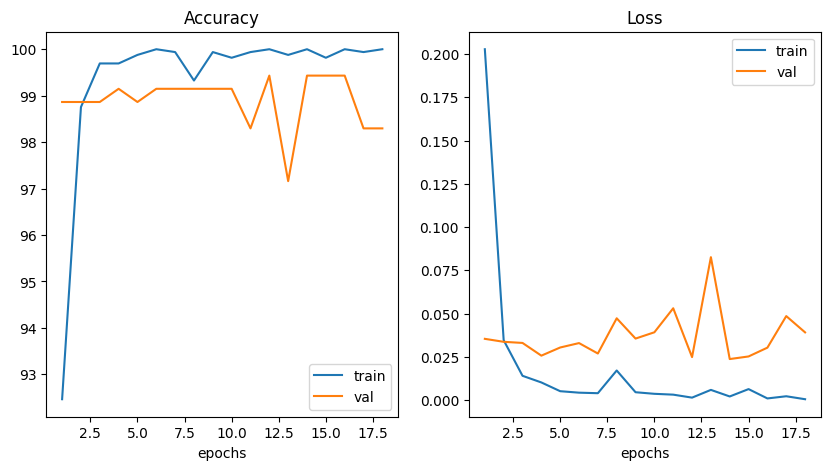

In [68]:
# Draw plots of how the training went
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(train_data_df.index + 1, # fixing epochs starting from 0 instead of 1
             train_data_df[['train_accuracy', 'val_accuracy']])
axes[0].set_title('Accuracy')
axes[0].set_xlabel('epochs')
axes[0].legend(['train', 'val'])
    
axes[1].plot(train_data_df.index + 1, 
             train_data_df[['train_loss', 'val_loss']])
axes[1].set_title('Loss')
axes[1].set_xlabel('epochs')
axes[1].legend(['train', 'val'])

plt.show();

#### Validate trained EfficientNetV2 model

In [70]:
# Load weights for best model
model.load_state_dict(torch.load(EFFNET_WEIGHTS))

<All keys matched successfully>

In [71]:
# Test model on validation data
progress_bar = tqdm(total=len(val_dataloader), ncols=100, position=0, leave=True)
    
running_accuracy = 0

model.eval()
    
with torch.no_grad():
    for images, labels in val_dataloader:
        outputs = model(images)

        # choose binary or multi-class classification accuracy to calculate
        if classification_type == 'binary':
            running_accuracy += calculate_accuracy_binary(outputs, labels)
        if classification_type == 'multi_class':
            running_accuracy += calculate_accuracy_multi_class(outputs, labels)
        
        progress_bar.update(1)
        
accuracy = running_accuracy / len(val_dataloader)
        
progress_bar.close() 
    
print('Accuracy of predictions on val data:', accuracy)

100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.87it/s]

Accuracy of predictions on val data: 0.9943181818181818


#### Let's test the EfficientNetV2 model (as if on real data)

In [72]:
# Create dataloader for test data
test_data = UnlabeledImageDataset(img_dir=TEST_DATA_DIR,
                                  transform=transforms) 

# Create pytorch dataloaders
test_dataloader = DataLoader(test_data, 
                             batch_size=32,
                             generator=torch.Generator(device='cuda'),
                             shuffle=False,)

In [73]:
# Predict on test data
progress_bar = tqdm(total=len(test_dataloader), ncols=100, position=0, leave=True)
prediction_results = []    

model.eval()
    
with torch.no_grad():
    for images in test_dataloader:
        outputs = model(images)
        
        # choose binary or multi-class classification accuracy to calculate
        # Sigmoid result
        if classification_type == 'binary':
            predicted = torch.round(outputs)
        # Softmax result
        if classification_type == 'multi_class':
            _, predicted = torch.max(outputs, dim=1)
        
        predicted = predicted.tolist()
        prediction_results += predicted
        
        progress_bar.update(1)
        
progress_bar.close()

100%|█████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.95it/s]


In [74]:
# Calculate accuracy of predictions

# Check if predictions were made wrong
if len(prediction_results) != len(pistachio_data_test):
    print('Something wrong! "Predictions" contains different amount of images than "pistachio_data_test"')

# Get category names
categories = []

for category_dir in os.listdir(DATA_DIR):
    # Take only subfolders - they contain images
    if os.path.isdir(os.path.join(DATA_DIR, category_dir)):
        categories.append(category_dir)

# Set variable to count correct predictions
correct_predictions = 0

# Get test image names
images_list = [image_name for image_name in os.listdir(TEST_DATA_DIR)]
    
# Count correct predictions
for i in range(len(images_list)):
    # Get image name
    image_name = images_list[i]
    
    # Get predicted label
    if classification_type == 'binary':
        pred_index = int(prediction_results[i][0])
    # Softmax result
    if classification_type == 'multi_class':
        pred_index = prediction_results[i] 
    
    pred_label = categories[pred_index]
    
    # Row orders in 'pistachio_data_test' and 'prediction_results' are different
    # So we have to get groud truth label by image name
    ground_truth_label = pistachio_data_test.loc[pistachio_data_test['id'] == image_name]['label'].item()
    
    if ground_truth_label == pred_label:
        correct_predictions += 1

print('Accuracy of predictions on test data:', correct_predictions / len(prediction_results))

Accuracy of predictions on test data: 0.9900497512437811


# Create and train AlexNet

https://en.wikipedia.org/wiki/AlexNet
<br>
https://dl.acm.org/doi/pdf/10.1145/3065386

### Prepare data
AlexNet has input size 227x227.

In [75]:
# List of transformation required for image before it will go to model
transforms = v2.Compose([
    v2.Resize(size=[227, 227], antialias=True), # 600 -> 227
    # ConvertImageDtype will be depricated soon. You will have to use ToDtype instead.
    v2.ConvertImageDtype(torch.float32), # scale pixel values from [0, 255] to [0, 1]
#     v2.ToDtype(torch.float32, scale=True),
])

In [76]:
# Create pytorch datasets using image transformations and label encoding
train_data = LabeledImageDataset(annotations_file='pistachio_data_train.csv', 
                                 img_dir=DATA_DIR,
                                 transform=transforms,
                                 # choose binary or multi-class classification encoder
#                                  target_transform=encode_label_binary, 
                                 target_transform=encode_label_multi_class,
                                ) 

val_data = LabeledImageDataset(annotations_file='pistachio_data_val.csv',
                               img_dir=DATA_DIR,
                               transform=transforms,
                               # choose binary or multi-class classification encoder
#                                target_transform=encode_label_binary, 
                               target_transform=encode_label_multi_class,
                              ) 

# Create pytorch dataloaders
# Shuffle training data - it improves training efficiency
train_dataloader = DataLoader(train_data, 
                              batch_size=32, 
                              generator=torch.Generator(device='cuda'),
                              shuffle=True)
val_dataloader = DataLoader(val_data, 
                            batch_size=32, 
                            generator=torch.Generator(device='cuda'),
                            shuffle=False)

### Prepare model

In [92]:
# Set type image classification

# classification_type = 'binary'
classification_type = 'multi_class'

if classification_type == 'binary':
    num_classes = 1
    loss_fn = torch.nn.BCELoss()

elif classification_type == 'multi_class':
    num_classes = len(categories)
    loss_fn = torch.nn.CrossEntropyLoss()

In [93]:
# Path to save model weights
ALEXNET_WEIGHTS = os.path.join(WORK_DIR, 'AlexNet_best_weights.pt')

In [94]:
# Reproducing AlexNet architecture
# Disabled some layers, added Sigmoid activation for binary classification

class NeuralNetwork(nn.Module):
    def __init__(self, num_classes: int, prediction_type=None, classification_type=None):
        # Extend functionality of inherited method
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Flatten(),
            
            nn.Linear(6 * 6 * 256, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            # There are not enough data to properly train such model
            # So some layers are disabled, to reduce model's size
#             nn.Linear(4096, 4096),
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
         
            nn.Linear(4096, num_classes),
        )
        
        # There was no Sigdmoid layer in original work
        self.activation = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        
        if classification_type =='binary':
            x = self.activation(x)
        return x

In [95]:
# PyTorch creates model with random weights
seed = 42
torch.manual_seed(seed)
model = NeuralNetwork(num_classes=num_classes, 
                      classification_type=classification_type,
                     )
print(model)

NeuralNetwork(
  (layers): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=9216, out_features=4096, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.5, inplace=False)
    (17): Linear(in_features=4096, out_features=2, bias=True)
  )
  (activation): Sigmoid()
)


In [96]:
num_epochs = 20

# Higher patience than before, because this model is not pretrained
# and has older and less efficient architecture, so it requires longer training.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopper_accuracy = EarlyStopperAccuracy(patience=5, min_delta=0)

train_stats = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_loop(model=model, 
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            classification_type=classification_type)
        
    val_loss, val_accuracy = val_loop(model=model, 
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      classification_type=classification_type)
    
    result = (
        f'Epoch [{epoch+1}/{num_epochs}], '
        f'Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}, '
        f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.4f}'
    )
        
    print(result)  
    
    # Collect training stats to draw plot later
    train_stats.append((train_loss, train_accuracy, val_loss, val_accuracy))
    
    # save weights with best results
    if early_stopper_accuracy.update_model_weights(val_accuracy):   
        torch.save(model.state_dict(), ALEXNET_WEIGHTS)
        
    # early stopping
    if early_stopper_accuracy.early_stop(val_accuracy): 
        break

100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.27it/s]


Epoch [1/20], Train loss: 0.6868, Train accuracy: 0.5711, Val loss: 0.5712, Val accuracy: 0.7377


100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.80it/s]


Epoch [2/20], Train loss: 0.4980, Train accuracy: 0.7437, Val loss: 0.4384, Val accuracy: 0.8011


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.29it/s]


Epoch [3/20], Train loss: 0.4215, Train accuracy: 0.8017, Val loss: 0.3836, Val accuracy: 0.7973


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.48it/s]


Epoch [4/20], Train loss: 0.3978, Train accuracy: 0.8225, Val loss: 0.4889, Val accuracy: 0.7547


100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.84it/s]


Epoch [5/20], Train loss: 0.3812, Train accuracy: 0.8315, Val loss: 0.3621, Val accuracy: 0.8333


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.48it/s]


Epoch [6/20], Train loss: 0.3965, Train accuracy: 0.8194, Val loss: 0.4334, Val accuracy: 0.7775


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.04it/s]


Epoch [7/20], Train loss: 0.3936, Train accuracy: 0.8225, Val loss: 0.3750, Val accuracy: 0.8248


100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.78it/s]


Epoch [8/20], Train loss: 0.3653, Train accuracy: 0.8438, Val loss: 0.4144, Val accuracy: 0.7983


100%|███████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.59it/s]


Epoch [9/20], Train loss: 0.3949, Train accuracy: 0.8233, Val loss: 0.3806, Val accuracy: 0.7917


100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.39it/s]

Epoch [10/20], Train loss: 0.3640, Train accuracy: 0.8366, Val loss: 0.3402, Val accuracy: 0.8277


#### Plot results of training AlexNet

In [97]:
# Validation accuracy is higher than training because dropout layers are not working during model.eval()
train_data_df = pd.DataFrame(train_stats, columns=['train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])
train_data_df['train_accuracy'] = train_data_df['train_accuracy'] * 100
train_data_df['val_accuracy'] = train_data_df['val_accuracy'] * 100
train_data_df

,train_loss,train_accuracy,val_loss,val_accuracy
0,0.686780,57.107843,0.571243,73.768939
1,0.497977,74.366830,0.438368,80.113636
2,0.421454,80.167484,0.383584,79.734848
3,0.397754,82.250817,0.488917,75.473485
4,0.381197,83.149510,0.362077,83.333333
5,0.396459,81.944444,0.433427,77.746212
6,0.393650,82.250817,0.374977,82.481061
7,0.365267,84.375000,0.414353,79.829545
8,0.394898,82.332516,0.380633,79.166667
9,0.363990,83.660131,0.340168,82.765152


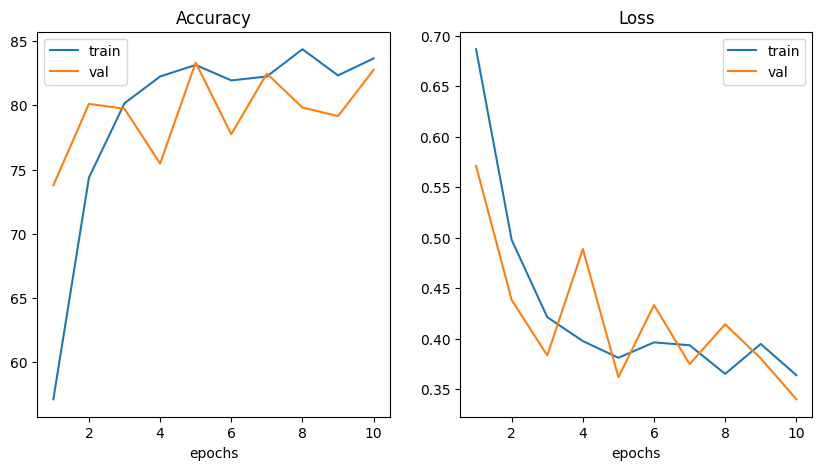

In [98]:
# Draw plots of how the training went
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(train_data_df.index + 1, # fixing epochs starting from 0 instead of 1
             train_data_df[['train_accuracy', 'val_accuracy']])
axes[0].set_title('Accuracy')
axes[0].set_xlabel('epochs')
axes[0].legend(['train', 'val'])
    
axes[1].plot(train_data_df.index + 1, 
             train_data_df[['train_loss', 'val_loss']])
axes[1].set_title('Loss')
axes[1].set_xlabel('epochs')
axes[1].legend(['train', 'val'])

plt.show();

#### Validate trained AlexNet model

In [99]:
# Load weights of model with best results
model.load_state_dict(torch.load(ALEXNET_WEIGHTS))

<All keys matched successfully>

In [100]:
# Test model on validation data

# We need to send data to GPU
device = torch.device('cuda')

progress_bar = tqdm(total=len(val_dataloader), ncols=100, position=0, leave=True)
    
running_accuracy = 0

model.eval()
    
with torch.no_grad():
    for images, labels in val_dataloader:
        # Send data to GPU
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)

        # choose binary or multi-class classification accuracy to calculate
        if classification_type == 'binary':
            running_accuracy += calculate_accuracy_binary(outputs, labels)
        if classification_type == 'multi_class':
            running_accuracy += calculate_accuracy_multi_class(outputs, labels)
        
        progress_bar.update(1)
        
accuracy = running_accuracy / len(val_dataloader)
        
progress_bar.close() 
    
print('Accuracy of predictions on val data:', accuracy)

100%|███████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.10it/s]

Accuracy of predictions on val data: 0.8333333333333333


#### Let's test the AlexNet model (as if on real data)

In [101]:
# Create dataloader for test data
test_data = UnlabeledImageDataset(img_dir=TEST_DATA_DIR,
                                  transform=transforms) 

# Create pytorch dataloaders
test_dataloader = DataLoader(test_data, 
                             batch_size=32,
                             generator=torch.Generator(device='cuda'),
                             shuffle=False,)

In [102]:
# Predict on test data

# We need to send data to GPU
device = torch.device('cuda')

progress_bar = tqdm(total=len(test_dataloader), ncols=100, position=0, leave=True)
prediction_results = []    

model.eval()
    
with torch.no_grad():
    for images in test_dataloader:
        # Send data to GPU
        images = images.to(device)
        
        outputs = model(images)
        
        # choose binary or multi-class classification accuracy to calculate
        # Sigmoid result
        if classification_type == 'binary':
            predicted = torch.round(outputs)
        # Softmax result
        if classification_type == 'multi_class':
            _, predicted = torch.max(outputs, dim=1)
        
        predicted = predicted.tolist()
        prediction_results += predicted
        
        progress_bar.update(1)
        
progress_bar.close()

100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.28it/s]


In [103]:
# Calculate accuracy of predictions

# Check if predictions were made wrong
if len(prediction_results) != len(pistachio_data_test):
    print('Something wrong! "Predictions" contains different amount of images than "pistachio_data_test"')

# Get category names
categories = []

for category_dir in os.listdir(DATA_DIR):
    # Take only subfolders - they contain images
    if os.path.isdir(os.path.join(DATA_DIR, category_dir)):
        categories.append(category_dir)

# Set variable to count correct predictions
correct_predictions = 0

# Get test image names
images_list = [image_name for image_name in os.listdir(TEST_DATA_DIR)]
    
# Count correct predictions
for i in range(len(images_list)):
    # Get image name
    image_name = images_list[i]
    
    # Get predicted label
    if classification_type == 'binary':
        pred_index = int(prediction_results[i][0])
    # Softmax result
    if classification_type == 'multi_class':
        pred_index = prediction_results[i] 
    
    pred_label = categories[pred_index]
    
    # Row orders in 'pistachio_data_test' and 'prediction_results' are different
    # So we have to get groud truth label by image name
    ground_truth_label = pistachio_data_test.loc[pistachio_data_test['id'] == image_name]['label'].item()
    
    if ground_truth_label == pred_label:
        correct_predictions += 1

print('Accuracy of predictions on test data:', correct_predictions / len(prediction_results))

Accuracy of predictions on test data: 0.8059701492537313
